In [10]:
import pandas as pd
import numpy as np
from math import log
import operator
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class Tree():
    def __init__(self, X, predict_feature):
        self.X = X
        self.predict_feature = predict_feature
        self.output_classes, self.class_count = np.unique(X[predict_feature], return_counts=True)
        self.features = list(self.X.columns)
        self.features.remove(predict_feature)
        
class Node(Tree):
    def __init__(self, X, predict_feature):
        super().__init__(X, predict_feature)
        self.node_entropy = self.entropy(X)

    def isLeaf(self):
        return len(np.unique(self.X[self.predict_feature])) == 1
        
    def entropy(self, input_data):
        _, value_count = np.unique(input_data[self.predict_feature], return_counts=True)
        prob = value_count/len(input_data)
        entropy = 0
        for i in range(0, len(value_count)):
            entropy += prob[i]*np.log2(prob[i])
        return -entropy
    
    def avgChildEntropy(self, feature):
        split_classes = np.unique(self.X[feature])
        nodes = []
        for i in range(0, len(split_classes)):
            nodes.append(self.X[self.X[feature]==split_classes[i]])
        
        n_parent = len(self.X)
        avg_entropy = 0
        for i in range(0, len(nodes)):
            avg_entropy+= (len(nodes[i])/n_parent)*self.entropy(nodes[i])
        
        return avg_entropy
    
    def infoGain(self, feature):
        return self.node_entropy - self.avgChildEntropy(feature)
    
    def split_info(self, feature):
        unique_classes, counts = np.unique(self.X[feature], return_counts=True)
        split_info = 0
        for i in range(0, len(unique_classes)):
            split_info-= (counts[i]/len(self.X))*np.log2((counts[i]/len(self.X)))
        return split_info  
    
    def indi_gini(self, node): #pass in child data
        node_gini = 1
        for i in range(0, len(self.output_classes)):
            node_gini-=(len(node[node[self.predict_feature]==self.output_classes[i]])/len(node))**2
        return node_gini
    
    def overall_gini(self, feature): #parent
        split_classes = np.unique(self.X[feature])
        overall_gini = 0
        for i in range(0, len(split_classes)):
            overall_gini += (len(self.X[self.X[feature]==split_classes[i]])/len(self.X))*self.indi_gini(self.X[self.X[feature]==split_classes[i]])
        return overall_gini   
    
    def split_select_gain_ratio(self):
        highest_ratio = 0
        self.selected_feature = ""
        for feature in self.features:
            if (self.split_info(feature)>0) and (self.infoGain(feature)/self.split_info(feature) > highest_ratio):
                highest_ratio = self.infoGain(feature)/self.split_info(feature)
                self.selected_feature = feature
        return self.selected_feature, highest_ratio
  
    def split_select_gini(self): #returns feature with lowest gini index
        lowest_gini = 0.67
        self.selected_feature = ""
        for feature in self.features:
            if (self.overall_gini(feature)) < lowest_gini and (feature != ''):
                lowest_gini = self.overall_gini(feature)
                self.selected_feature = feature

        return self.selected_feature, lowest_gini
    
    def split_select_infoGain(self):
        highest_gain = 0
        self.selected_feature = ""
        for feature in self.features:
            if self.infoGain(feature) > highest_gain:
                highest_gain = self.infoGain(feature)
                self.selected_feature = feature
        return self.selected_feature, highest_gain  

    def split(self, split_by): 
        split_list= {} #each element is a node after splitting
        split_values = np.unique(self.X[split_by])
        for i in range(0, len(split_values)):
            node = pd.DataFrame(self.X[self.X[split_by]==split_values[i]])
            node = node.drop(columns=[split_by])
            split_list[split_values[i]] = node
            #split_list.append(node)
        return split_list




In [3]:
def leafClassifer(data, labelCol): 
    classes, n_classes = np.unique(data[labelCol], return_counts=True)

    return classes[n_classes.argmax()] #returns most frequent output class


def decision_tree(data, labelCol, split_method, min_split, max_depth, depth_count=0):
    node = Node(data,labelCol)
    if node.isLeaf() or len(node.X) <min_split or len(node.X.columns)==1 or depth_count==max_depth: #default value for recursion
        return leafClassifer(data, labelCol)
    else:
        depth_count+=1
        if split_method=="Information_Gain":
            node.split_select_infoGain()
        if split_method=="Gini_Index":
            node.split_select_gini()
        if split_method=="Gain_Ratio":
            node.split_select_gain_ratio()
        if node.selected_feature =="":
            asd, asd_count = np.unique(node.X[labelCol], return_counts=True)
            return asd[asd_count.argmax()]
        split_nodes = node.split(node.selected_feature)
    
        myTree = {node.selected_feature:{}}
        
        for subnode_name, subnode_data in split_nodes.items():
            myTree[node.selected_feature][subnode_name] = decision_tree(subnode_data,labelCol, split_method,min_split, max_depth, depth_count)
        return myTree


def predict(input_row, input_tree):
    split_column = list(input_tree.keys())[0]
    for key,value in input_tree[split_column].items():
        if input_row[split_column] == key:
            if type(value).__name__ == 'str':
                return value
            else:
                return predict(input_row, input_tree[split_column][key])


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

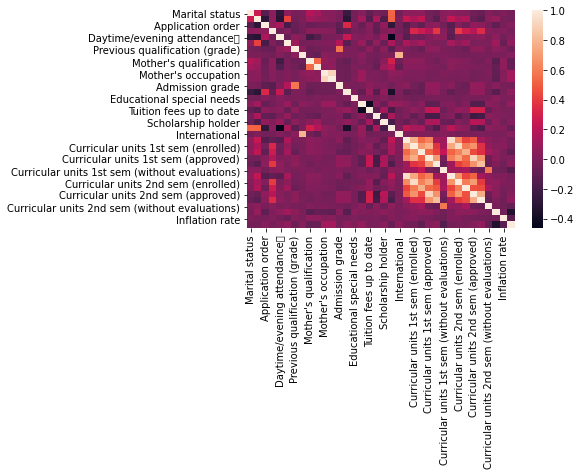

In [12]:
df= pd.read_csv("data.csv", sep=";")
labels = df.iloc[:,-1:]
sns.heatmap(df.corr())

In [5]:
df["Previous qualification (grade)"] = pd.cut(df["Previous qualification (grade)"], 3)
df["Curricular units 2nd sem (grade)"] = pd.cut(df["Curricular units 2nd sem (grade)"], 3)
df["Admission grade"] = pd.cut(df["Admission grade"], 3)
df["Curricular units 1st sem (grade)"] = pd.cut(df["Curricular units 1st sem (grade)"], 3)
df["Unemployment rate"] = pd.cut(df["Unemployment rate"], 3)
df["Inflation rate"] = pd.cut(df["Inflation rate"], 3)
df["GDP"] = pd.cut(df["GDP"], 3)

In [6]:
df_train = df.iloc[0:3300]
df_test = df.iloc[3300:]

In [7]:
#DT split using Information Gain
info_gain_tree = decision_tree(df_train, "Target", "Information_Gain", 150, 15)
df_test["predicted"] = df_test.apply(predict, args=(info_gain_tree,), axis=1)
accuracy=len(df_test[df_test["Target"] == df_test["predicted"]])/len(df_test)
print(accuracy)

0.7090747330960854


<ipython-input-7-13994b5cdbab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["predicted"] = df_test.apply(predict, args=(info_gain_tree,), axis=1)


In [8]:
#DT split using Gain Ratio
gain_ratio_tree = decision_tree(df_train, "Target", "Gain_Ratio", 200, 10)
df_test = df_test.drop(columns="predicted")
df_test["predicted"] = df_test.apply(predict, args=(gain_ratio_tree,), axis=1)
accuracy=len(df_test[df_test["Target"] == df_test["predicted"]])/len(df_test)
print(accuracy)

0.7215302491103203


In [9]:
#DT split using Gini Index
gini_tree = decision_tree(df_train, "Target", "Gini_Index", 50, 10)
df_test = df_test.drop(columns="predicted")
df_test["predicted"] = df_test.apply(predict, args=(gini_tree,), axis=1)
accuracy=len(df_test[df_test["Target"] == df_test["predicted"]])/len(df_test)
print(accuracy)

0.6761565836298933
